NOTEBOOK 06: CLASSIFICATION MODELS


Mục tiêu: Chuyển bài toán hồi quy sang phân loại và đánh giá các mô hình

1. Import Libraries và Load Data

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
import json
import joblib
import time

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

# Load normalized data
df = pd.read_csv('../data/processed/data_normalized.csv')
print(f"✓ Data loaded: {df.shape}")

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
print(f"✓ Target variable: {target_col}")

# Prepare features
y_continuous = df[target_col].values
X = df.drop(target_col, axis=1).values
feature_names = df.drop(target_col, axis=1).columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_continuous.shape}")

# Load PCA-reduced data
df_pca_reduced = pd.read_csv('../data/processed/pca_1/3_original.csv')
X_pca = df_pca_reduced.drop(target_col, axis=1).values
print(f"PCA-reduced shape: {X_pca.shape}")

✓ Libraries imported successfully!
✓ Data loaded: (1470, 48)
✓ Target variable: JobSatisfaction

Features shape: (1470, 47)
Target shape: (1470,)
PCA-reduced shape: (1470, 15)


2.Create Classification Labels

In [32]:
# Analyze target distribution
print("\nOriginal JobSatisfaction distribution:")
print(pd.Series(y_continuous).value_counts().sort_index())

# Method 1: Equal width bins
y_class_equal = pd.cut(y_continuous, bins=[0, 2, 3, 5],
                       labels=['Low', 'Medium', 'High']).astype(str)

# Method 2: Quantile-based (balanced classes)
y_class_quantile = pd.qcut(y_continuous, q=3, labels=['Low', 'Medium', 'High'],
                           duplicates='drop').astype(str)

# Method 3: Based on actual values (1-2: Low, 3: Medium, 4-5: High)
y_class_manual = pd.cut(y_continuous, bins=[0, 2.5, 3.5, 5],
                        labels=['Low', 'Medium', 'High']).astype(str)

print("\n" + "="*70)
print("LABEL DISTRIBUTION COMPARISON")
print("="*70)

methods = {
    'Equal Width': y_class_equal,
    'Quantile-based': y_class_quantile,
    'Manual': y_class_manual
}

for method_name, labels in methods.items():
    print(f"\n{method_name}:")
    print(pd.Series(labels).value_counts())
    print(f"Balance: {pd.Series(labels).value_counts().std():.2f} (lower is better)")

# Choose the most balanced method
balance_scores = {name: pd.Series(labels).value_counts().std()
                 for name, labels in methods.items()}
best_method = min(balance_scores, key=balance_scores.get)
y_class = methods[best_method]

print(f"\n✓ Selected method: {best_method}")
print(f"✓ Final class distribution:")
print(pd.Series(y_class).value_counts())

# Encode labels to numeric
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_class)
class_names = le.classes_

print(f"\nClass encoding:")
for i, class_name in enumerate(class_names):
    print(f"  {i}: {class_name}")

# Save label mapping
label_mapping = {i: name for i, name in enumerate(class_names)}
with open('../results/metrics/classification_label_mapping.json', 'w') as f:
    json.dump(label_mapping, f, indent=4)


Original JobSatisfaction distribution:
1    289
2    280
3    442
4    459
Name: count, dtype: int64

LABEL DISTRIBUTION COMPARISON

Equal Width:
Low       569
High      459
Medium    442
Name: count, dtype: int64
Balance: 68.94 (lower is better)

Quantile-based:
Low       569
High      459
Medium    442
Name: count, dtype: int64
Balance: 68.94 (lower is better)

Manual:
Low       569
High      459
Medium    442
Name: count, dtype: int64
Balance: 68.94 (lower is better)

✓ Selected method: Equal Width
✓ Final class distribution:
Low       569
High      459
Medium    442
Name: count, dtype: int64

Class encoding:
  0: High
  1: Low
  2: Medium


3.Visualize Class Distribution

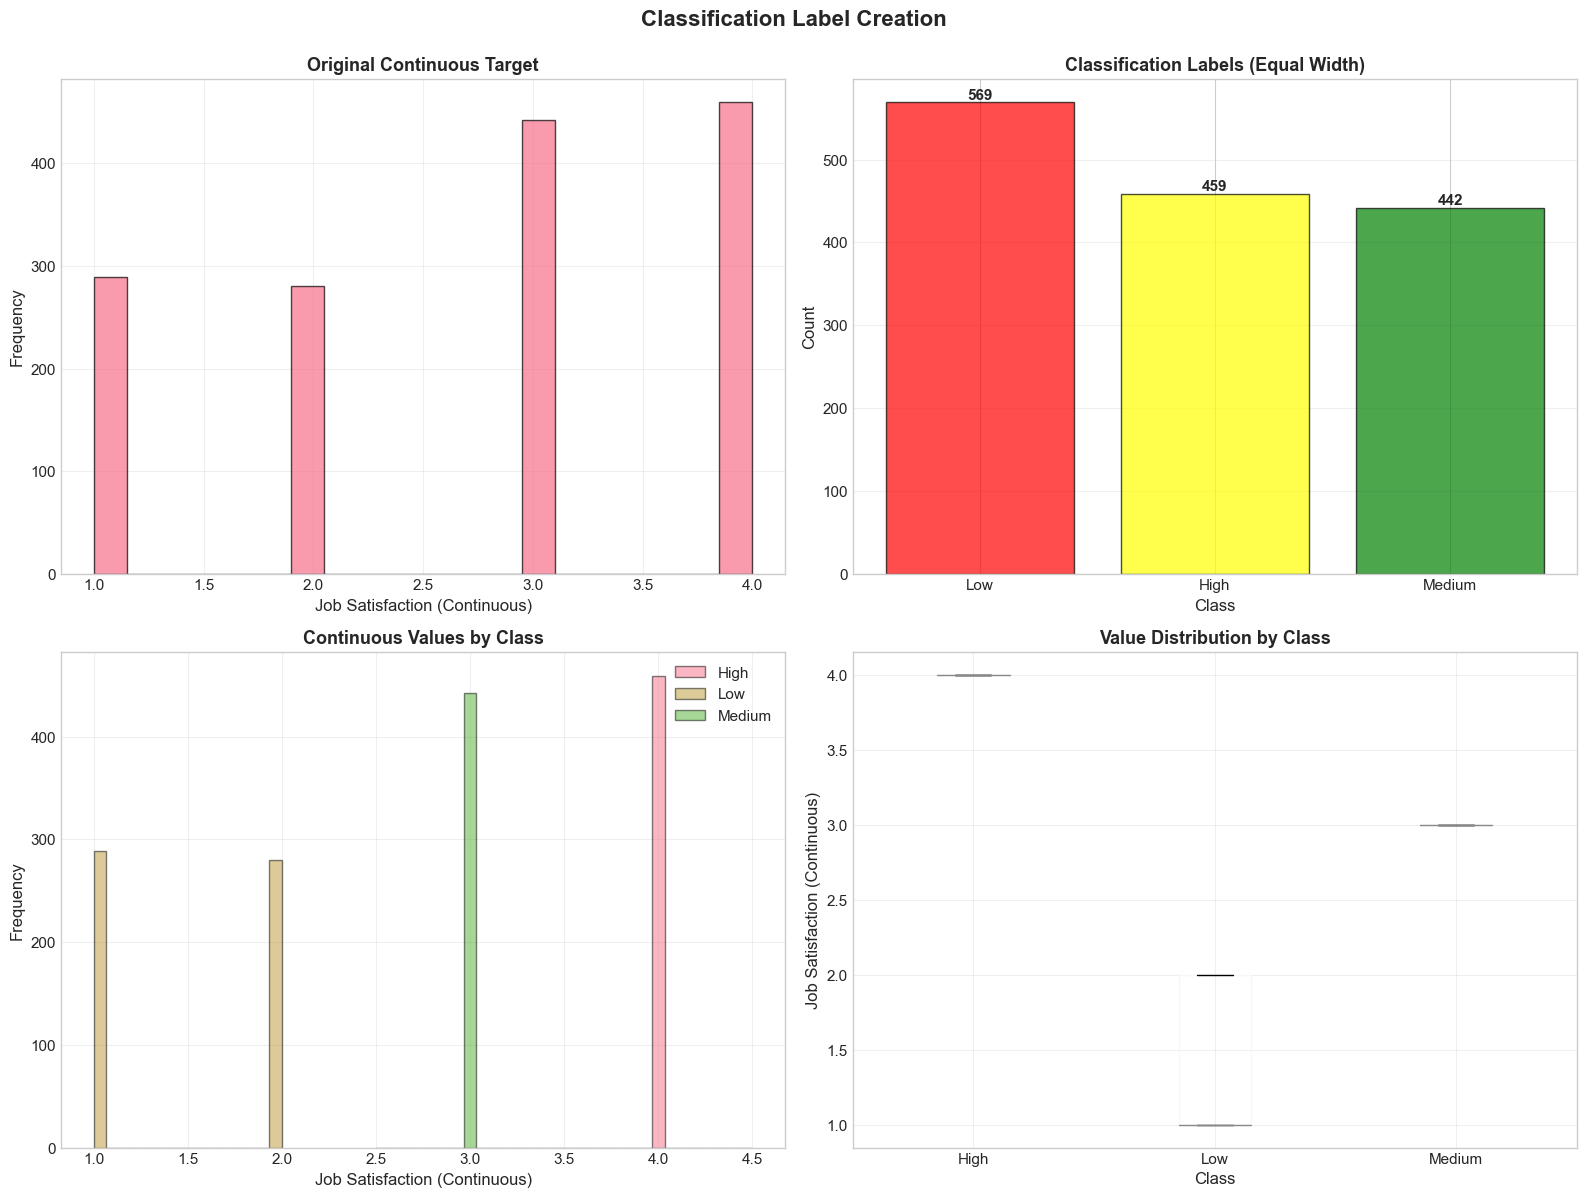

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Original continuous distribution
axes[0, 0].hist(y_continuous, bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Job Satisfaction (Continuous)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Original Continuous Target', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Classification labels
class_counts = pd.Series(y_class).value_counts()
axes[0, 1].bar(class_counts.index, class_counts.values,
               color=['red', 'yellow', 'green'], edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Class', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].set_title(f'Classification Labels ({best_method})',
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, (label, count) in enumerate(class_counts.items()):
    axes[0, 1].text(i, count, str(count), ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

# 3. Class distribution by original value
df_viz = pd.DataFrame({'Continuous': y_continuous, 'Class': y_class})
for class_name in class_names:
    class_data = df_viz[df_viz['Class'] == class_name]['Continuous']
    axes[1, 0].hist(class_data, bins=15, alpha=0.5, label=class_name, edgecolor='black')
axes[1, 0].set_xlabel('Job Satisfaction (Continuous)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Continuous Values by Class', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of classes
df_viz.boxplot(column='Continuous', by='Class', ax=axes[1, 1])
axes[1, 1].set_xlabel('Class', fontsize=12)
axes[1, 1].set_ylabel('Job Satisfaction (Continuous)', fontsize=12)
axes[1, 1].set_title('Value Distribution by Class', fontsize=13, fontweight='bold')
axes[1, 1].get_figure().suptitle('')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Classification Label Creation', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/classification/label_distribution.png',
            dpi=300, bbox_inches='tight')
plt.show()

4.Define Classification Models

In [34]:
models = {
    # Naive Bayes (Generative)
    'Naive Bayes': GaussianNB(),

    # Logistic Regression (Discriminative, Linear)
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Logistic L2 (C=0.1)': LogisticRegression(C=0.1, max_iter=1000, random_state=42),

    # Decision Tree (Non-linear)
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Decision Tree (deep)': DecisionTreeClassifier(max_depth=20, random_state=42),

    # Random Forest
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                           random_state=42, n_jobs=-1),

    # SVM (Discriminative, Non-linear)
    'SVM (linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (rbf)': SVC(kernel='rbf', random_state=42, probability=True),

    # K-NN
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),

    # Neural Network
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500,
                        random_state=42, early_stopping=True)
}

print(f"\nTotal models: {len(models)}")
print("\nModel categories:")
print("  Generative: Naive Bayes")
print("  Discriminative Linear: Logistic Regression, SVM (linear)")
print("  Discriminative Non-linear: Decision Tree, Random Forest, SVM (rbf), KNN, MLP")


Total models: 10

Model categories:
  Generative: Naive Bayes
  Discriminative Linear: Logistic Regression, SVM (linear)
  Discriminative Non-linear: Decision Tree, Random Forest, SVM (rbf), KNN, MLP


5. Train-Test Split Configuration

In [35]:
split_configs = [
    {'name': '80:20', 'train_size': 0.8, 'test_size': 0.2},
    {'name': '70:30', 'train_size': 0.7, 'test_size': 0.3},
    {'name': '60:40', 'train_size': 0.6, 'test_size': 0.4}
]

print("\nSplit configurations:")
for config in split_configs:
    n_train = int(len(X) * config['train_size'])
    n_test = int(len(X) * config['test_size'])
    print(f"  {config['name']}: {n_train} train, {n_test} test")


Split configurations:
  80:20: 1176 train, 294 test
  70:30: 1029 train, 441 test
  60:40: 882 train, 588 test


6.Experiment Function

In [36]:
def train_and_evaluate_classifier(model, X_train, X_test, y_train, y_test):
    """Train classifier and compute metrics"""
    start_time = time.time()

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    train_precision = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)

    train_recall = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)

    train_f1 = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

    elapsed_time = time.time() - start_time

    # Get probabilities if available
    try:
        y_pred_proba = model.predict_proba(X_test)
    except:
        y_pred_proba = None

    return {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'training_time': elapsed_time,
        'y_pred_test': y_pred_test,
        'y_pred_proba': y_pred_proba,
        'trained_model': model  # ĐỔI TÊN KEY ĐỂ TRÁNH NHẦM LẪN
    }

7.Run Experiments - Original Data

In [37]:
results_original = []

for split_config in split_configs:
    split_name = split_config['name']
    test_size = split_config['test_size']

    print(f"\n{'='*70}")
    print(f"Split: {split_name}")
    print('='*70)

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )

    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Test class distribution: {np.bincount(y_test)}")

    for model_name, model in models.items():
        print(f"\n  Training {model_name}...", end=' ')

        try:
            metrics = train_and_evaluate_classifier(model, X_train, X_test, y_train, y_test)

            result = {
                'model': model_name,
                'data_type': 'Original',
                'split': split_name,
                'n_features': X.shape[1],
                **metrics
            }
            results_original.append(result)

            print(f"✓ Acc={metrics['test_accuracy']:.4f}, F1={metrics['test_f1']:.4f}")

        except Exception as e:
            print(f"✗ Error: {str(e)}")

df_results_original = pd.DataFrame(results_original)


Split: 80:20
Train size: 1176, Test size: 294
Train class distribution: [367 455 354]
Test class distribution: [ 92 114  88]

  Training Naive Bayes... ✓ Acc=0.3401, F1=0.3368

  Training Logistic Regression... ✓ Acc=0.3878, F1=0.3793

  Training Logistic L2 (C=0.1)... ✓ Acc=0.3912, F1=0.3832

  Training Decision Tree... ✓ Acc=0.3231, F1=0.3222

  Training Decision Tree (deep)... ✓ Acc=0.3503, F1=0.3517

  Training Random Forest... ✓ Acc=0.3810, F1=0.3352

  Training SVM (linear)... ✓ Acc=0.3469, F1=0.3341

  Training SVM (rbf)... ✓ Acc=0.4082, F1=0.3764

  Training KNN (k=5)... ✓ Acc=0.3639, F1=0.3520

  Training MLP... ✓ Acc=0.3231, F1=0.2934

Split: 70:30
Train size: 1029, Test size: 441
Train class distribution: [321 398 310]
Test class distribution: [138 171 132]

  Training Naive Bayes... ✓ Acc=0.3333, F1=0.3357

  Training Logistic Regression... ✓ Acc=0.3537, F1=0.3464

  Training Logistic L2 (C=0.1)... ✓ Acc=0.3560, F1=0.3456

  Training Decision Tree... ✓ Acc=0.3696, F1=0.358

8.Run Experiments - PCA-Reduced Data

In [38]:
results_pca = []

for split_config in split_configs:
    split_name = split_config['name']
    test_size = split_config['test_size']

    print(f"\n{'='*70}")
    print(f"Split: {split_name}")
    print('='*70)

    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )

    print(f"Train size: {X_train_pca.shape[0]}, Test size: {X_test_pca.shape[0]}")

    for model_name, model in models.items():
        print(f"\n  Training {model_name}...", end=' ')

        try:
            metrics = train_and_evaluate_classifier(model, X_train_pca, X_test_pca,
                                                   y_train, y_test)

            result = {
                'model': model_name,
                'data_type': 'PCA',
                'split': split_name,
                'n_features': X_pca.shape[1],
                **metrics
            }
            results_pca.append(result)

            print(f"✓ Acc={metrics['test_accuracy']:.4f}, F1={metrics['test_f1']:.4f}")

        except Exception as e:
            print(f"✗ Error: {str(e)}")

df_results_pca = pd.DataFrame(results_pca)


Split: 80:20
Train size: 1176, Test size: 294

  Training Naive Bayes... ✓ Acc=0.3741, F1=0.3673

  Training Logistic Regression... ✓ Acc=0.3605, F1=0.3125

  Training Logistic L2 (C=0.1)... ✓ Acc=0.3537, F1=0.3029

  Training Decision Tree... ✓ Acc=0.3401, F1=0.3237

  Training Decision Tree (deep)... ✓ Acc=0.3163, F1=0.3161

  Training Random Forest... ✓ Acc=0.3537, F1=0.3284

  Training SVM (linear)... ✓ Acc=0.3878, F1=0.2167

  Training SVM (rbf)... ✓ Acc=0.3946, F1=0.3605

  Training KNN (k=5)... ✓ Acc=0.3673, F1=0.3537

  Training MLP... ✓ Acc=0.3265, F1=0.3082

Split: 70:30
Train size: 1029, Test size: 441

  Training Naive Bayes... ✓ Acc=0.3560, F1=0.3536

  Training Logistic Regression... ✓ Acc=0.3787, F1=0.3455

  Training Logistic L2 (C=0.1)... ✓ Acc=0.3764, F1=0.3415

  Training Decision Tree... ✓ Acc=0.3447, F1=0.3290

  Training Decision Tree (deep)... ✓ Acc=0.3243, F1=0.3242

  Training Random Forest... ✓ Acc=0.3583, F1=0.3381

  Training SVM (linear)... ✓ Acc=0.3878, F

9.Combine and Save Results

In [48]:
# Combine results
df_results_all = pd.concat([df_results_original, df_results_pca], ignore_index=True)

# Save export version - CHỈ drop các cột array/object không serialize được
df_results_all_export = df_results_all.drop(columns=['y_pred_test', 'y_pred_proba'], errors='ignore')

# Nếu cột 'model' chứa objects thì convert sang string
if 'model' in df_results_all_export.columns:
    first_val = df_results_all_export['model'].iloc[0]
    if not isinstance(first_val, str):
        df_results_all_export['model'] = df_results_all_export['model'].apply(
            lambda x: x.__class__.__name__ if hasattr(x, '__class__') else str(x)
        )

# Save results
df_results_all_export.to_csv('../results/metrics/classification_results_detailed.csv', index=False)
print("✓ Saved: classification_results_detailed.csv")

# Display summary
print("\nResults Summary:")
print(df_results_all_export[['model', 'data_type', 'split',
                              'test_accuracy', 'test_f1']].to_string(index=False))

✓ Saved: classification_results_detailed.csv

Results Summary:
               model data_type split  test_accuracy  test_f1
         Naive Bayes  Original 80:20       0.340136 0.336800
 Logistic Regression  Original 80:20       0.387755 0.379309
 Logistic L2 (C=0.1)  Original 80:20       0.391156 0.383191
       Decision Tree  Original 80:20       0.323129 0.322156
Decision Tree (deep)  Original 80:20       0.350340 0.351664
       Random Forest  Original 80:20       0.380952 0.335156
        SVM (linear)  Original 80:20       0.346939 0.334122
           SVM (rbf)  Original 80:20       0.408163 0.376393
           KNN (k=5)  Original 80:20       0.363946 0.351963
                 MLP  Original 80:20       0.323129 0.293351
         Naive Bayes  Original 70:30       0.333333 0.335717
 Logistic Regression  Original 70:30       0.353741 0.346406
 Logistic L2 (C=0.1)  Original 70:30       0.356009 0.345640
       Decision Tree  Original 70:30       0.369615 0.358712
Decision Tree (deep)  

10.Best Models Analysis

In [49]:
best_by_acc = df_results_all.loc[df_results_all['test_accuracy'].idxmax()]
best_by_f1 = df_results_all.loc[df_results_all['test_f1'].idxmax()]

print("\nBest Model by Accuracy:")
print(f"  Model: {best_by_acc['model']}")
print(f"  Data: {best_by_acc['data_type']}")
print(f"  Split: {best_by_acc['split']}")
print(f"  Test Accuracy: {best_by_acc['test_accuracy']:.4f}")
print(f"  Test F1: {best_by_acc['test_f1']:.4f}")

print("\nBest Model by F1-Score:")
print(f"  Model: {best_by_f1['model']}")
print(f"  Data: {best_by_f1['data_type']}")
print(f"  Split: {best_by_f1['split']}")
print(f"  Test Accuracy: {best_by_f1['test_accuracy']:.4f}")
print(f"  Test F1: {best_by_f1['test_f1']:.4f}")

# Average performance
print("\n" + "="*70)
print("AVERAGE PERFORMANCE BY MODEL")
print("="*70)

avg_performance = df_results_all.groupby('model')[['test_accuracy', 'test_precision',
                                                     'test_recall', 'test_f1']].mean()
avg_performance = avg_performance.sort_values('test_f1', ascending=False)
print(avg_performance)


Best Model by Accuracy:
  Model: SVM (rbf)
  Data: Original
  Split: 80:20
  Test Accuracy: 0.4082
  Test F1: 0.3764

Best Model by F1-Score:
  Model: Logistic L2 (C=0.1)
  Data: Original
  Split: 80:20
  Test Accuracy: 0.3912
  Test F1: 0.3832

AVERAGE PERFORMANCE BY MODEL
                      test_accuracy  test_precision  test_recall   test_f1
model                                                                     
Naive Bayes                0.348450        0.347878     0.348450  0.345352
SVM (rbf)                  0.375000        0.357355     0.375000  0.341389
Logistic Regression        0.363851        0.346290     0.363851  0.340295
KNN (k=5)                  0.351002        0.347576     0.351002  0.339675
Logistic L2 (C=0.1)        0.363851        0.344343     0.363851  0.338634
Random Forest              0.363662        0.341392     0.363662  0.332152
Decision Tree              0.340136        0.333300     0.340136  0.331589
Decision Tree (deep)       0.327003        0.3279

11.Performance Comparison Visualization

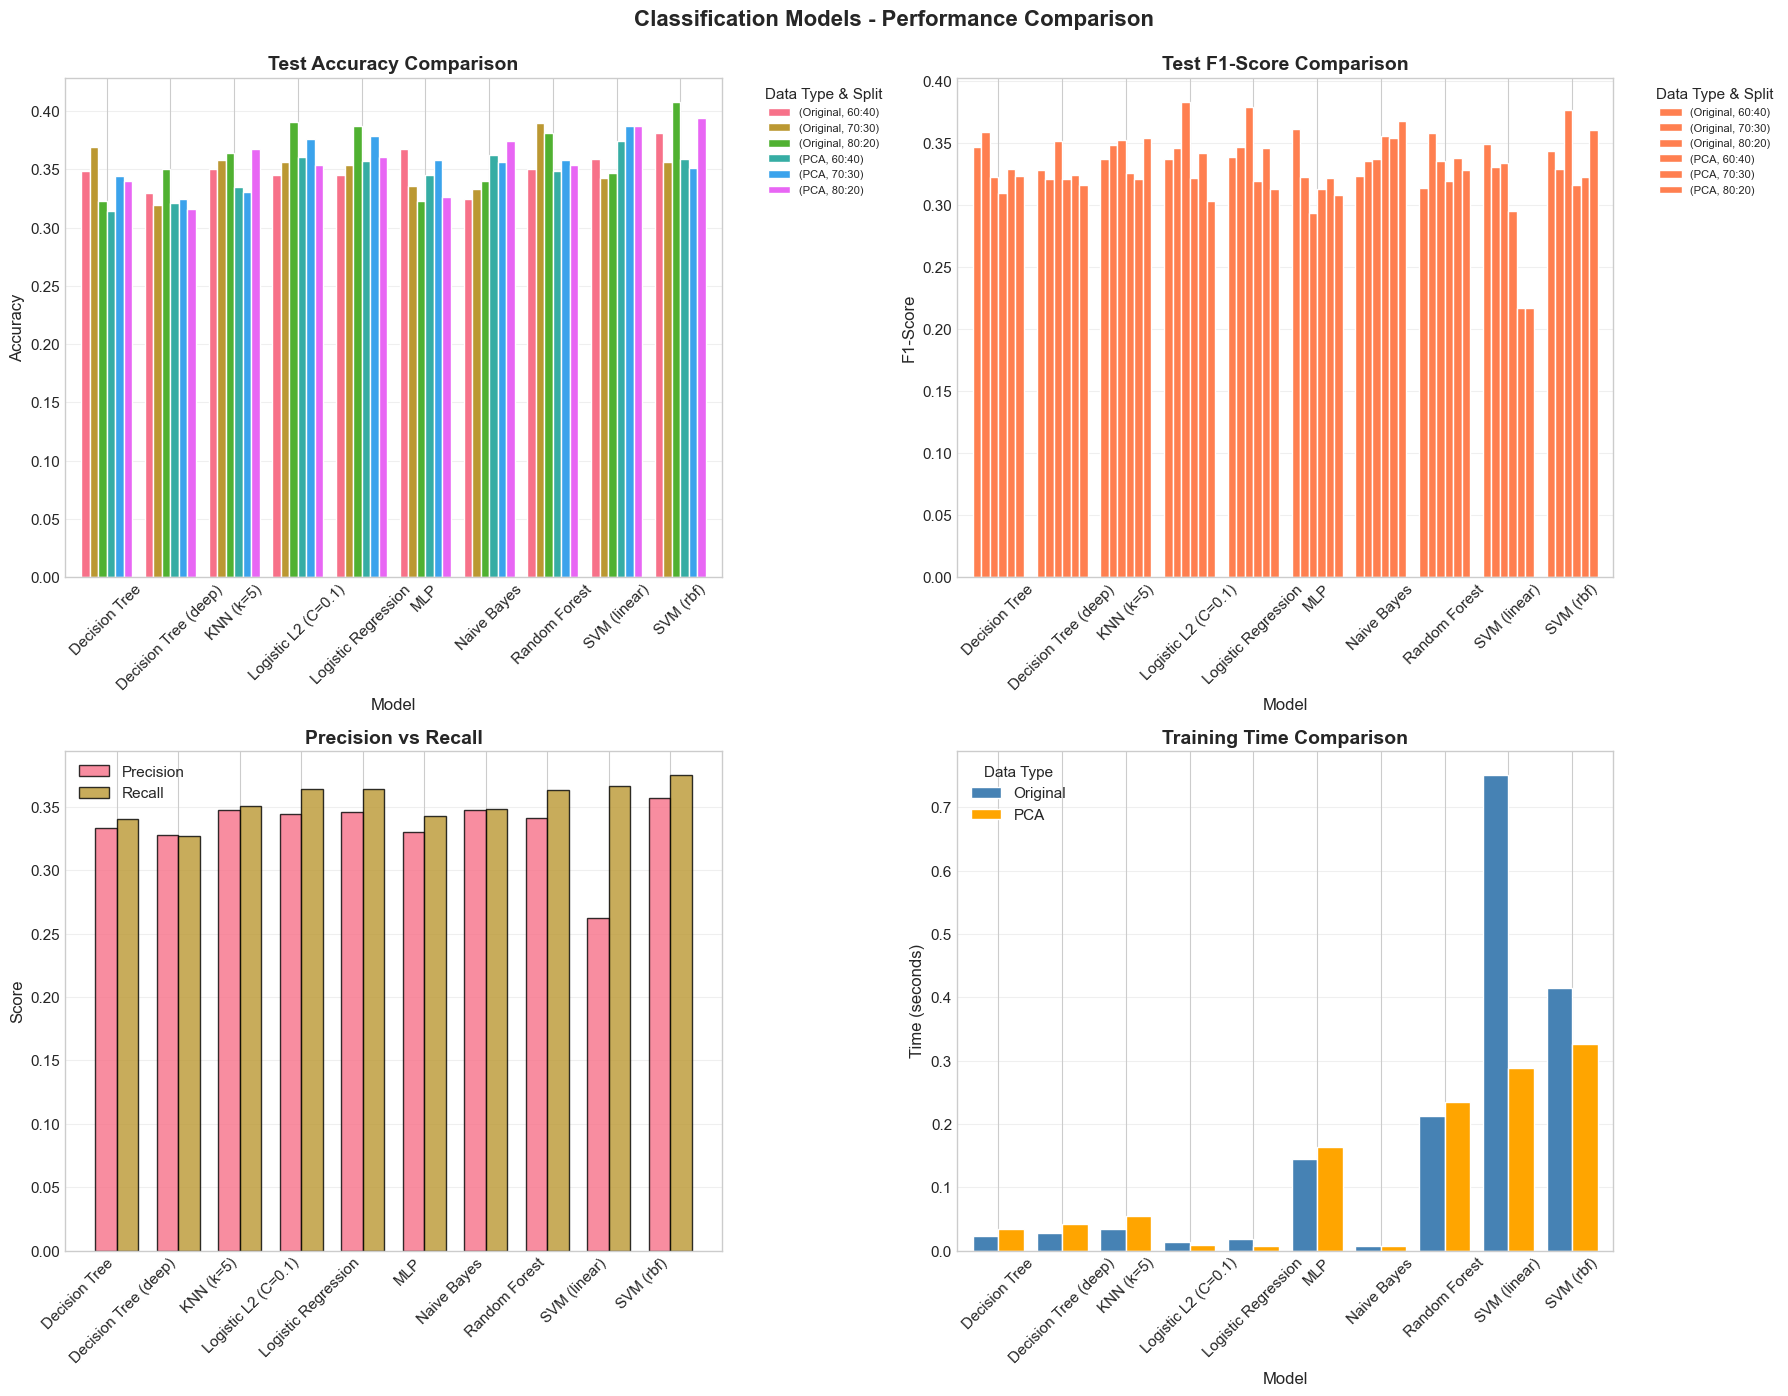

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Accuracy comparison
pivot_acc = df_results_all_export.pivot_table(
    values='test_accuracy',
    index='model',
    columns=['data_type', 'split']
)
pivot_acc.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].legend(title='Data Type & Split', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. F1-Score comparison
pivot_f1 = df_results_all_export.pivot_table(
    values='test_f1',
    index='model',
    columns=['data_type', 'split']
)
pivot_f1.plot(kind='bar', ax=axes[0, 1], width=0.8, color='coral')
axes[0, 1].set_title('Test F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].legend(title='Data Type & Split', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Precision vs Recall
avg_by_model = df_results_all_export.groupby('model')[['test_precision', 'test_recall']].mean()
x_pos = np.arange(len(avg_by_model))
width = 0.35
axes[1, 0].bar(x_pos - width/2, avg_by_model['test_precision'], width,
               label='Precision', alpha=0.8, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, avg_by_model['test_recall'], width,
               label='Recall', alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(avg_by_model.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Training time
pivot_time = df_results_all_export.pivot_table(
    values='training_time',
    index='model',
    columns='data_type'
)
pivot_time.plot(kind='bar', ax=axes[1, 1], width=0.8, color=['steelblue', 'orange'])
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_xlabel('Model', fontsize=12)
axes[1, 1].legend(title='Data Type')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Classification Models - Performance Comparison',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/classification/performance_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

12.Confusion Matrices - Best Models

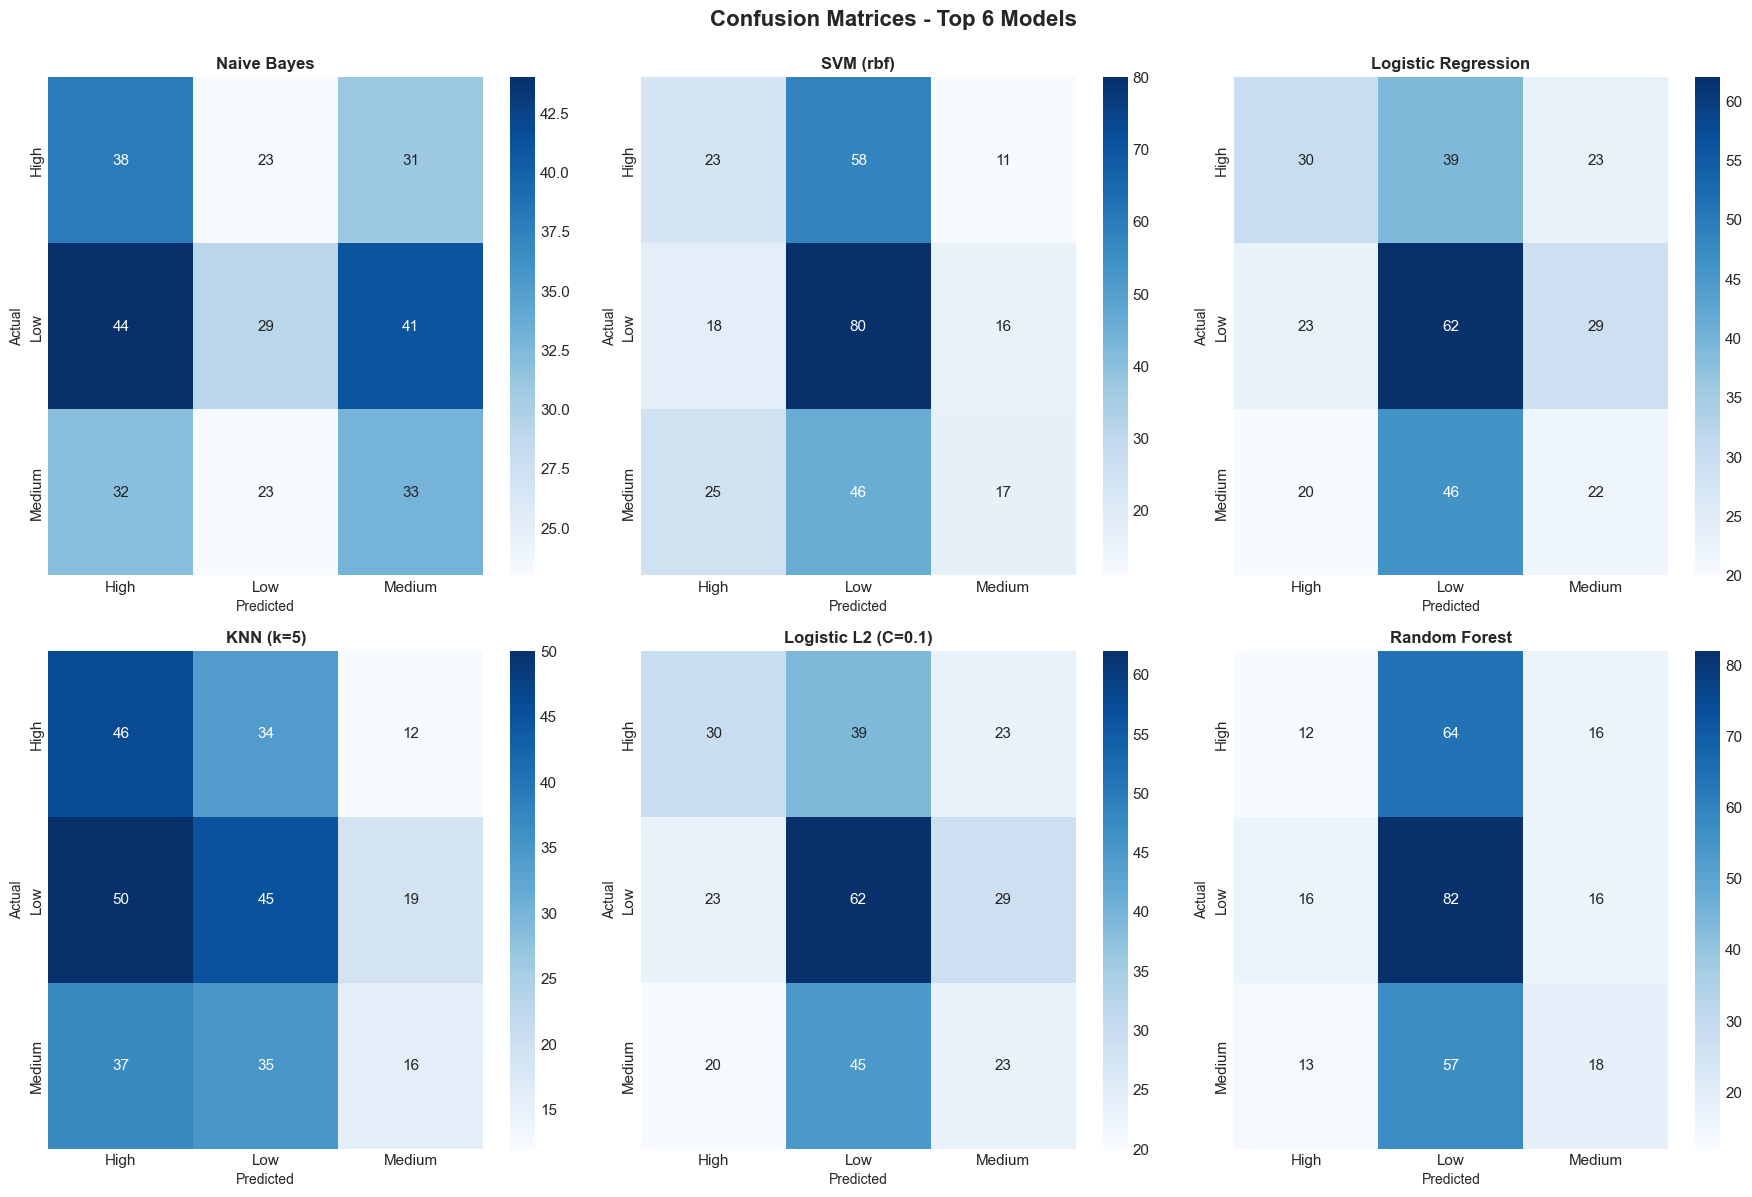

In [51]:
# Get top 6 models by average F1
top_models = avg_performance.head(6).index.tolist()

# Train models with 80:20 split for confusion matrix
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, model_name in enumerate(top_models):
    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.suptitle('Confusion Matrices - Top 6 Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/classification/confusion_matrices_top6.png',
            dpi=300, bbox_inches='tight')
plt.show()

13.Detailed Analysis - Best Model


Best model: Naive Bayes

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        High       0.33      0.41      0.37        92
         Low       0.39      0.25      0.31       114
      Medium       0.31      0.38      0.34        88

    accuracy                           0.34       294
   macro avg       0.34      0.35      0.34       294
weighted avg       0.35      0.34      0.34       294



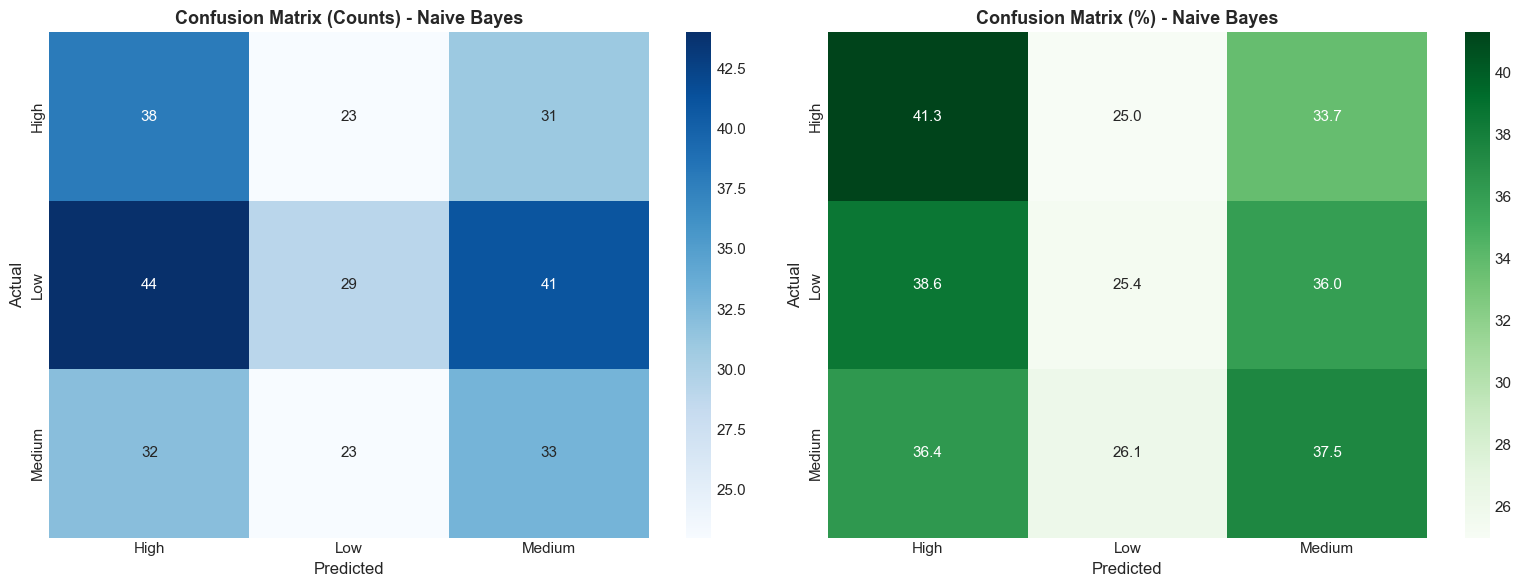

In [52]:
best_model_name = avg_performance.index[0]
print(f"\nBest model: {best_model_name}")

# Train best model
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion matrix with percentages
cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'Confusion Matrix (Counts) - {best_model_name}',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Percentage
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'Confusion Matrix (%) - {best_model_name}',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.savefig('../results/figures/classification/confusion_matrix_best_detailed.png',
            dpi=300, bbox_inches='tight')
plt.show()

14.ROC Curves (if probabilities available)

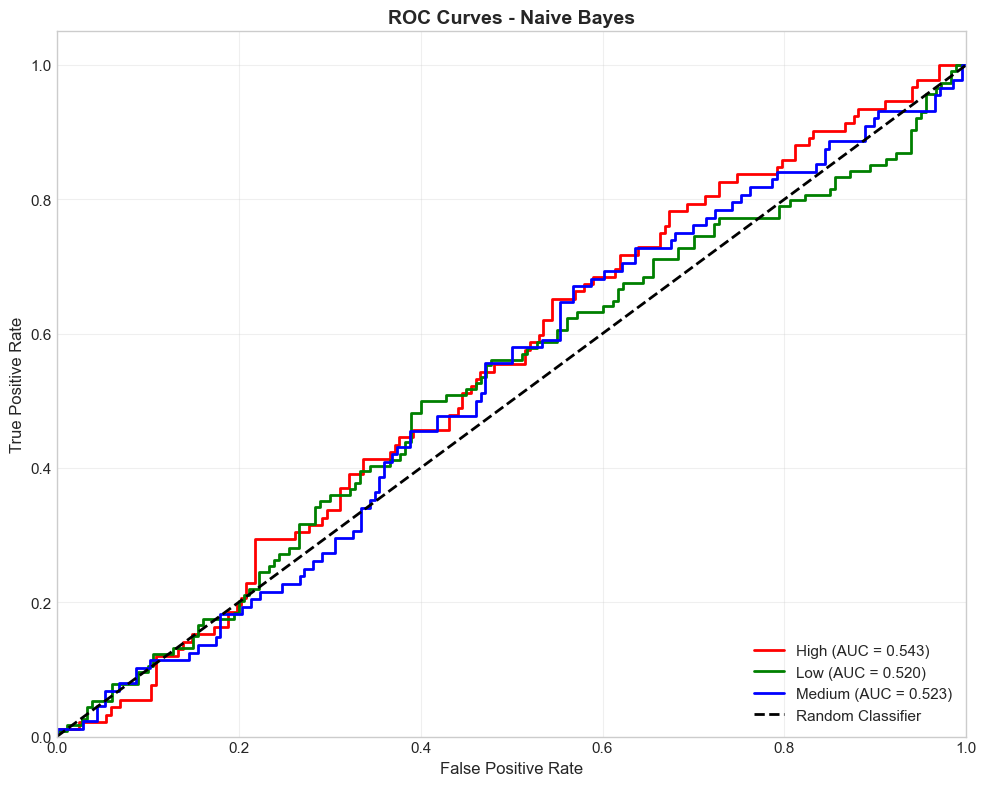

✓ ROC curves saved!

AUC Scores:
  High: 0.5433
  Low: 0.5200
  Medium: 0.5233


In [53]:
# Check if best model supports probability
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test)

    # Binarize the output for ROC curve
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['red', 'green', 'blue']

    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/figures/classification/roc_curves.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ ROC curves saved!")
    print("\nAUC Scores:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {roc_auc[i]:.4f}")
else:
    print("⚠ Best model does not support probability predictions")